In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.light_palette((210, 90, 60), input="husl", n_colors=50))
my_cmap = ListedColormap(sns.diverging_palette(220, 20, n=50))
my_cmap = ListedColormap(sns.color_palette("RdBu_r", 50))
my_cmap = ListedColormap(sns.color_palette("coolwarm", 50))

from matplotlib.colors import to_rgb, to_rgba

def scatter(x, y, color, alpha_arr, **kwarg):
    r, g, b = to_rgb(color)
    # r, g, b, _ = to_rgba(color)
    color = [(r, g, b, alpha) for alpha in alpha_arr]
    plt.scatter(x, y, c=color, **kwarg)

In [3]:
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

from torch import distributions
from torch import nn
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import sys
sys.path.append('../')
from core import networks
from core import toy_data

In [4]:
device = torch.device('cpu')

In [5]:
def sample_data(name, batch_size):
    x = toy_data.inf_train_gen(name, batch_size=batch_size)
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

def plot_samples(samples):
    _ = plt.hist2d(samples[:,0], samples[:,1], bins=50, cmap=my_cmap)
    
@torch.no_grad()
def plot_ebm_density(ebm):
    x = torch.linspace(-3.,3.,100)
    y = torch.linspace(-3.,3.,100)
    x_grid,y_grid = torch.meshgrid(x,y)
    pdf = torch.exp(-ebm(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2])))
    pdf = pdf.numpy().reshape([100, 100])
    plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)
    
def plot_dist(dist):
    x = torch.linspace(-1.,4.,100)
    y = torch.linspace(-1.,4.,100)
    x_grid,y_grid = torch.meshgrid(x,y)
    pdf = torch.exp(dist.log_prob(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2])))
    pdf = pdf.numpy().reshape([100, 100])
    plt.contourf(x_grid, y_grid, pdf, levels=30, cmap=my_cmap)

In [49]:
dt = 1e-1
sigma = np.sqrt(dt)
n_samples = 1000
n_iter = 1000
data_dim = 2
beta_schedule = np.linspace(0.0,1.0, n_iter)

target = toy_data.gaussian_grid_2d(size=4)

init_dist = distributions.MultivariateNormal(1.5*torch.ones(2), torch.eye(2))
samples = init_dist.sample([n_samples])
init_samples = samples.clone()
samples = torch.autograd.Variable(samples, requires_grad=True)
log_w = torch.zeros(n_samples)
# log_w += -data_dim/2.*np.log(2*np.pi)
log_prob = lambda x, beta: (beta*target.log_prob(x)+(1-beta)*init_dist.log_prob(x))
dEdt = lambda x: (-target.log_prob(x)+init_dist.log_prob(x))
history = [samples.clone()]
for i in range(1,n_iter):
    beta, beta_prev = beta_schedule[i], beta_schedule[i-1]
    with torch.no_grad():
        log_w += log_prob(samples,beta) - log_prob(samples,beta_prev)
    grad = torch.autograd.grad(-dEdt(samples).sum(), samples)[0].detach()
    samples.data += (beta-beta_prev)*grad
    history.append(samples.clone())
Z = torch.exp(log_w).mean()
print(Z.numpy())

3.2107077


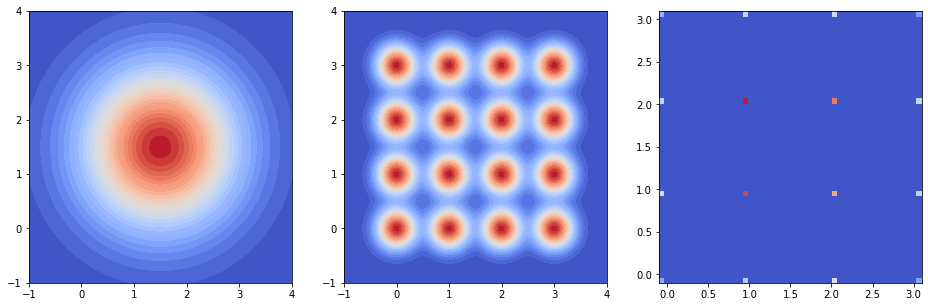

In [50]:
figsize(16,5)
plt.subplot(131)
plot_dist(init_dist)
plt.subplot(132)
plot_dist(target)
plt.subplot(133)
plot_samples(samples.detach().numpy())

In [186]:
dt = 1e-1
sigma = np.sqrt(dt)
n_samples = 1000
n_iter = 1000
data_dim = 2
beta_schedule = np.linspace(0.0,1.0, n_iter)

target = toy_data.gaussian_grid_2d(size=4)

init_dist = distributions.MultivariateNormal(1.5*torch.ones(2), torch.eye(2))
samples = init_dist.sample([n_samples])
samples = torch.autograd.Variable(samples, requires_grad=True)
log_w = torch.zeros(n_samples)
# log_w += -data_dim/2.*np.log(2*np.pi)
log_prob = lambda x, beta: (beta*target.log_prob(x)+(1-beta)*init_dist.log_prob(x))
acceptance_rate = 0.0
for i in range(1,n_iter):
    beta, beta_prev = beta_schedule[i], beta_schedule[i-1]
    with torch.no_grad():
        log_w += log_prob(samples,beta) - log_prob(samples,beta_prev)
    grad = torch.autograd.grad(log_prob(samples, beta).sum(), samples)[0].detach()
    proposals = samples.data + dt/2. * grad + torch.randn_like(samples) * sigma
    proposals = torch.autograd.Variable(proposals, requires_grad=True)
    grad_p = torch.autograd.grad(log_prob(proposals, beta).sum(), proposals)[0].detach()
    with torch.no_grad():
        log_P = log_prob(proposals.data, beta)-log_prob(samples.data, beta)
        log_P += - 0.5/sigma**2*((samples-(proposals+dt/2.*grad_p))**2).view(-1, data_dim).sum(1)
        log_P += + 0.5/sigma**2*((proposals-(samples+dt/2.*grad))**2).view(-1, data_dim).sum(1)
        log_U = torch.log(torch.rand_like(log_P))
    accept_mask = log_P > log_U
    acceptance_rate += accept_mask.float().mean()
    samples.data[accept_mask] = proposals.data[accept_mask]
acceptance_rate /= n_iter
Z = torch.exp(log_w).mean()
print(acceptance_rate, Z)

tensor(0.8749) tensor(1.0033)


0.9575851440429689
0.9800805664062502


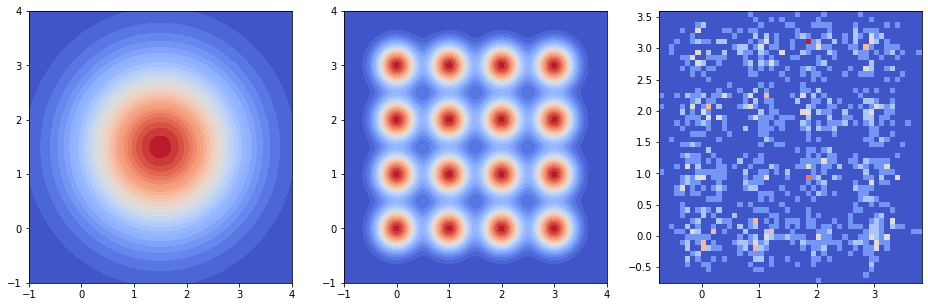

In [187]:
figsize(16,5)
plt.subplot(131)
plot_dist(init_dist)
plt.subplot(132)
plot_dist(target)
plt.subplot(133)
plot_samples(samples.detach().numpy())

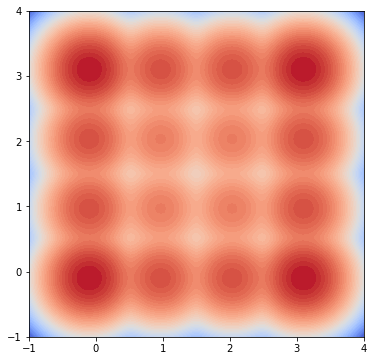

In [37]:
figsize(6,6)
x = torch.linspace(-1.,4.,100)
y = torch.linspace(-1.,4.,100)
x_grid,y_grid = torch.meshgrid(x,y)
pdf = target.log_prob(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2]))
pdf -= init_dist.log_prob(torch.stack([x_grid, y_grid], axis=2).reshape([-1, 2]))
pdf = pdf.numpy().reshape([100, 100])
plt.contourf(x_grid, y_grid, pdf, levels=500, cmap=my_cmap)
# plt.scatter(hist[:,0], hist[:,1])